In [160]:
import pandas as pd
import plotly.express as px
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv",index_col=0)
df.Datum = pd.to_datetime(df["Datum"])
df.set_index(df["Datum"],inplace=True)

#Annahme: Regelmäßige Zeiten machen den Großteil der Fälle aus, wenn z.B. nachts jemand da ist ist manuelles einschalten zumutbar. 
#Eventuell könnte die Automatik auch nur in der Arbeitszeit aktiv werden. Wir legen den Fokus des Modells
#auf Werte innerhalb der Arbeitszeit und daher halten wir hier ein gewisses Overfitting für vertretbar.
df["Arbeitszeit"] = (df["Datum"].dt.hour.between(8,17))&(df["Datum"].dt.dayofweek < 5)&~((df["Datum"].dt.hour==13)&(df["Datum"].dt.minute.between(0,15)))

#Leichte Glättung um Streuung besser abzubilden
df["Arbeitszeit"] = df["Arbeitszeit"].astype(int).ewm(com=10).mean() 

#Multikolinearität vermeiden; Laut Aufgabenstellung wird der Wassergehalt
#aus Luftfeuchtigkeit und Temperatur abgeleitet
df.drop(["Datum","Wassergehalt"],axis=1,inplace=True) 
df.dropna(inplace=True)

#Gleiche Vorverarbeitung für die test.csv
df_test = pd.read_csv("test.csv",index_col=0)
df_test.Datum = pd.to_datetime(df_test["Datum"])
df_test.set_index(df_test["Datum"],inplace=True)
df_test["Arbeitszeit"] = (df_test["Datum"].dt.hour.between(8,17))&(df_test["Datum"].dt.dayofweek < 5)&~((df_test["Datum"].dt.hour==13)&(df_test["Datum"].dt.minute.between(0,20)))
df_test.drop(["Datum","Wassergehalt"],axis=1,inplace=True)
df_test.dropna(inplace=True)

In [161]:
px.bar(df.resample("h").mean(),y="CO2",color="Anwesenheit")

In [162]:
df.describe()

,Temperatur,Luftfeuchtigkeit,CO2,Anwesenheit,Arbeitszeit
count,14225.000000,14225.000000,14225.000000,14225.000000,1.422500e+04
mean,21.005722,25.941156,628.075549,0.256591,2.934535e-01
std,1.148986,4.581969,279.382924,0.436767,4.445397e-01
min,19.000000,16.745000,412.750000,0.000000,9.502077e-155
25%,20.290000,22.675000,446.000000,0.000000,4.631667e-32
50%,20.830000,25.722500,512.000000,0.000000,6.872680e-14
75%,21.700000,28.650000,694.750000,1.000000,9.862808e-01
max,24.408333,39.117500,2028.500000,1.000000,1.000000e+00


## Ausreißer werden entfernt
- macht keinen großen Unterschied für die Performance aber etwas sauberer
- fehlende Werte füllen wir nicht auf weil es nicht genug Daten gibt um sie verlässlich intelligent zu füllen


In [163]:
features = ["Luftfeuchtigkeit", "Temperatur", "CO2"]
for feature in features:
    df[f"Ausreisserdropper{feature}"] = df[feature]/df[feature].shift(1)
    Q1 = df[f"Ausreisserdropper{feature}"].quantile(0.04)
    Q3 = df[f"Ausreisserdropper{feature}"].quantile(0.96)
    IQR = Q3 - Q1
    df = df[~((df[f"Ausreisserdropper{feature}"] < (Q1 - 1.5 * IQR)) |(df[f"Ausreisserdropper{feature}"] > (Q3 + 1.5 * IQR)))]
########Begründung für 1.5
df.drop(columns=["AusreisserdropperTemperatur","AusreisserdropperLuftfeuchtigkeit","AusreisserdropperCO2"],inplace=True)
df.dropna(inplace=True)

df['Date'] = df.index.date
#02.02. wird ausgenommen, weil er unserer Ansicht nach nicht repräsentativ für den Großteil der Fälle ist.
mask = df.Date != pd.to_datetime('2017-02-02')
df = df[mask]
df.drop(["Date"],axis=1,inplace=True)

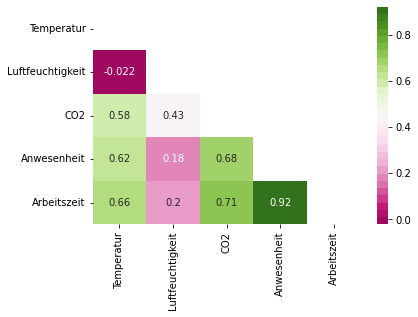

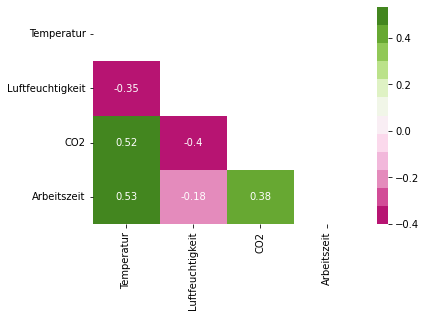

In [164]:
from seaborn import heatmap, color_palette
heatmap(df.corr(),annot=True,cmap=color_palette("PiYG", 30),mask=np.triu(df.corr()))
plt.show()
heatmap(df_test.corr(),annot=True,cmap=color_palette("PiYG", 12),mask=np.triu(df_test.corr()))
plt.show()
#Negativer statt positiver Zusammenhang für Luftfeuchtigkeit und CO2 bei den echten Testdaten!

## Funktion fürs Training

In [165]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay, plot_roc_curve,roc_auc_score,confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.svm import SVC

label = "Anwesenheit"

def report(m):
    '''Gibt den den Classification Report auf den Trainings- und Testdaten aus'''
    print("Trainingsdaten:\n",classification_report(y_train,m.predict(X_train),digits=3))
    print("Testdaten:\n",classification_report(y_test,m.predict(X_test),digits=3))

def test_viz(m):
    '''Plottet die vorhergesagte Anwesenheit auf den echten Testdaten'''
    if 'Anwesenheit' in df_test:
        df_test.drop(columns="Anwesenheit",inplace=True)
    df_test["Anwesenheit"] = m.predict(df_test)
    px.bar(df_test.resample("10min").mean(),y="CO2",color="Anwesenheit").show()
    df_test.drop(columns="Anwesenheit",inplace=True)

# Erste Modelle 

## Logistische Regression

In [166]:
# Erstellung eines einfachen df zum testen der ersten Modelle
df_e = df.drop(['Arbeitszeit'], axis = 1).reset_index()
df_e['Stunde'] = df_e.Datum.dt.hour
df_e['Wochenende'] = df_e.Datum.dt.day_of_week >= 5
X = df_e.drop(['Datum'], axis=1,inplace=True)

df_e.head()

,Temperatur,Luftfeuchtigkeit,CO2,Anwesenheit,Stunde,Wochenende
0,23.18,27.2720,721.25,1,17,False
1,23.15,27.2675,714.00,1,17,False
2,23.15,27.2450,713.50,1,17,False
3,23.15,27.2000,708.25,1,17,False
4,23.10,27.2000,704.50,1,17,False


In [167]:
X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

print('Trainingsdaten:\n', classification_report(y_train, model.predict(X_train)))
print('Testdaten:\n', classification_report(y_test, model.predict(X_test)))

Index(['Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Stunde', 'Wochenende'], dtype='object')
Trainingsdaten:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96      7268
           1       0.87      0.83      0.85      2261

    accuracy                           0.93      9529
   macro avg       0.91      0.90      0.90      9529
weighted avg       0.93      0.93      0.93      9529

Testdaten:
               precision    recall  f1-score   support

           0       0.76      0.97      0.86      2047
           1       0.90      0.45      0.60      1130

    accuracy                           0.79      3177
   macro avg       0.83      0.71      0.73      3177
weighted avg       0.81      0.79      0.77      3177



### Verbesserung des Modells mit den Hyperparametern

In [234]:
# Extrahierung von X,y von den DF
X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']

# Generierung der Dummy-Variablen aus Stunde
X = pd.get_dummies(X, columns=['Stunde'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = linear_model.LogisticRegression()
grid = {
"solver" : ["lbfgs","newton-cg"],
"C": [ 1.0, 0.1, 10]
}

clf = GridSearchCV(lr, grid, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.score(X_test, y_test))

{'C': 10, 'solver': 'lbfgs'}
0.9682090022033365


In [235]:
# Model mit den empfohlenen Hyperparametern
X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']

# Generierung der Dummy-Variablen aus Stunde
X = pd.get_dummies(X, columns=['Stunde'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

eLR = linear_model.LogisticRegression(**clf.best_params_,max_iter=10000)
eLR.fit(X_train, y_train)

report(eLR)

Trainingsdaten:
               precision    recall  f1-score   support

           0      0.970     0.978     0.974      6953
           1      0.940     0.917     0.928      2576

    accuracy                          0.962      9529
   macro avg      0.955     0.948     0.951      9529
weighted avg      0.962     0.962     0.962      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.978     0.980     0.979      2362
           1      0.941     0.935     0.938       815

    accuracy                          0.968      3177
   macro avg      0.959     0.957     0.958      3177
weighted avg      0.968     0.968     0.968      3177



## Decision Tree

In [170]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

X = df_e.drop(['Anwesenheit','Luftfeuchtigkeit'], axis = 1)
y = df_e['Anwesenheit']
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

model = DecisionTreeClassifier(max_depth=10)
model.fit(X_train, y_train)

report(model)

Index(['Temperatur', 'CO2', 'Stunde', 'Wochenende'], dtype='object')
Trainingsdaten:
               precision    recall  f1-score   support

           0      0.993     0.996     0.995      6953
           1      0.990     0.982     0.986      2576

    accuracy                          0.992      9529
   macro avg      0.992     0.989     0.990      9529
weighted avg      0.992     0.992     0.992      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.989     0.986     0.988      2362
           1      0.961     0.968     0.965       815

    accuracy                          0.982      3177
   macro avg      0.975     0.977     0.976      3177
weighted avg      0.982     0.982     0.982      3177



### Decision Tree wird mithilfe von Hyperparametern versucht zu verbessern

In [236]:
X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

random_grid = {
'max_depth': [2, 3, 5, 10, 20],
'criterion': ["gini", "entropy"]
}
dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, random_grid, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.score(X_test, y_test))

Index(['Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Stunde', 'Wochenende'], dtype='object')
{'criterion': 'entropy', 'max_depth': 20}
0.9858356940509915


In [237]:
# Model mit den empfohlenen Hyperparametern
X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

eDT = DecisionTreeClassifier(**clf.best_params_)
eDT.fit(X_train, y_train)

report(eDT)

Trainingsdaten:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000      6953
           1      1.000     1.000     1.000      2576

    accuracy                          1.000      9529
   macro avg      1.000     1.000     1.000      9529
weighted avg      1.000     1.000     1.000      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.991     0.991     0.991      2362
           1      0.974     0.974     0.974       815

    accuracy                          0.987      3177
   macro avg      0.983     0.983     0.983      3177
weighted avg      0.987     0.987     0.987      3177



## Random Forest

### Erstes Modell ohne die Hyperparameter zu verbessern

In [238]:
X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']
X_name = feature_names=list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

print("Trainingsdaten:\n",classification_report(y_train,model.predict(X_train)))
print("Testdaten:\n",classification_report(y_test,model.predict(X_test),digits=3))

Trainingsdaten:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6953
           1       1.00      1.00      1.00      2576

    accuracy                           1.00      9529
   macro avg       1.00      1.00      1.00      9529
weighted avg       1.00      1.00      1.00      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.994     0.990     0.992      2362
           1      0.972     0.983     0.977       815

    accuracy                          0.988      3177
   macro avg      0.983     0.987     0.985      3177
weighted avg      0.988     0.988     0.988      3177



### Tuning der Hyperparameter

In [239]:
X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)


scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf = RandomForestClassifier(random_state=42)
grid = {
"max_features" : ["auto", "sqrt", "log2"],    
"n_estimators" : [10,50,100,200],
'max_depth': [2, 3, 5, 10, 20],
}

clf = GridSearchCV(rf, grid, cv = 5)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.score(X_test, y_test))

{'max_depth': 20, 'max_features': 'auto', 'n_estimators': 10}
0.9870947434686811


In [241]:
X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']
X_name = feature_names=list(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

eRF = RandomForestClassifier(**clf.best_params_,random_state=42)
eRF.fit(X_train, y_train)

report(eRF)

Trainingsdaten:
               precision    recall  f1-score   support

           0      0.999     0.999     0.999      6953
           1      0.998     0.997     0.998      2576

    accuracy                          0.999      9529
   macro avg      0.999     0.998     0.999      9529
weighted avg      0.999     0.999     0.999      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.992     0.991     0.991      2362
           1      0.974     0.975     0.975       815

    accuracy                          0.987      3177
   macro avg      0.983     0.983     0.983      3177
weighted avg      0.987     0.987     0.987      3177



## SVM

### Einfaches SVM Modell
### Erste Verbesserungen bei dem Modell konnten vorgenommen werden mittels der Dummy Kodierung und der Interaktion

In [243]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']
print(X.columns)
X = pd.get_dummies(X, columns=['Stunde'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state = 42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = SVC()
model.fit(X_train, y_train)

report(model)

Index(['Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Stunde', 'Wochenende'], dtype='object')
Trainingsdaten:
               precision    recall  f1-score   support

           0      0.973     0.980     0.977      6953
           1      0.946     0.927     0.936      2576

    accuracy                          0.966      9529
   macro avg      0.959     0.954     0.957      9529
weighted avg      0.966     0.966     0.966      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.981     0.975     0.978      2362
           1      0.929     0.945     0.937       815

    accuracy                          0.967      3177
   macro avg      0.955     0.960     0.957      3177
weighted avg      0.967     0.967     0.967      3177



### Tuning der Hyperparameter der Support-Vector-Classification

In [244]:
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures

X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']
print(X.columns)
X = pd.get_dummies(X, columns=['Stunde'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, shuffle=False)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


svc = SVC()
grid = {
"C" : [ 0.1, 1, 10],
"kernel" : ["poly", "rbf", "sigmoid"], 
"degree" : [1, 2, 3]
}

clf = GridSearchCV(svc, grid, cv=5)
clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.score(X_test, y_test))

Index(['Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Stunde', 'Wochenende'], dtype='object')
{'C': 10, 'degree': 1, 'kernel': 'rbf'}
0.948693736229147


### Modell mit optimierten Hyperparametern

In [245]:
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures

X = df_e.drop(['Anwesenheit'], axis = 1)
y = df_e['Anwesenheit']
print(X.columns)
X = pd.get_dummies(X, columns=['Stunde'])


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, shuffle=False)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

eSVC = SVC(**clf.best_params_)
eSVC.fit(X_train, y_train)

report(eSVC)

Index(['Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Stunde', 'Wochenende'], dtype='object')
Trainingsdaten:
               precision    recall  f1-score   support

           0      0.980     0.984     0.982      7268
           1      0.948     0.935     0.942      2261

    accuracy                          0.973      9529
   macro avg      0.964     0.960     0.962      9529
weighted avg      0.972     0.973     0.972      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.960     0.961     0.960      2047
           1      0.929     0.927     0.928      1130

    accuracy                          0.949      3177
   macro avg      0.944     0.944     0.944      3177
weighted avg      0.949     0.949     0.949      3177



# Mit Arbeitszeit als Label

## Logistische Regression

In [206]:
X = df.drop(columns=[label])
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr = linear_model.LogisticRegression()
grid = {
"solver" : ["newton-cg", "lbfgs", "sag"],
"C": [100, 10, 1.0, 0.1]
}

rsLR =  GridSearchCV(estimator = lr, param_grid = grid,cv = 5)
rsLR.fit(X_train,y_train)
print(rsLR.best_params_,"\n",rsLR.score(X_test, y_test))

{'C': 100, 'solver': 'newton-cg'} 
 0.9625432798237331


In [207]:
mLR = linear_model.LogisticRegression(**rsLR.best_params_)
mLR.fit(X_train, y_train)

report(mLR)
df_test["Anwesenheit"] = mLR.predict(scaler.transform(df_test))
px.bar(df_test.resample("10min").mean(),y="CO2",color="Anwesenheit").show()
df_test.drop(columns="Anwesenheit",inplace=True)

Trainingsdaten:
               precision    recall  f1-score   support

           0      0.981     0.969     0.975      6953
           1      0.918     0.948     0.933      2576

    accuracy                          0.963      9529
   macro avg      0.949     0.959     0.954      9529
weighted avg      0.964     0.963     0.963      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.985     0.964     0.975      2362
           1      0.902     0.958     0.929       815

    accuracy                          0.963      3177
   macro avg      0.944     0.961     0.952      3177
weighted avg      0.964     0.963     0.963      3177



## Random Forest

In [208]:
X = df.drop(columns=[label])
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf = RandomForestClassifier(random_state=42)
grid = {
"max_features" : ["auto", "sqrt", "log2"],    
"n_estimators" : [10,50,100,200],
'max_depth': [2, 3, 5, 10, 20],
}

rsRF =  GridSearchCV(estimator = rf, param_grid = grid,cv = 5)
rsRF.fit(X_train,y_train)
print(rsRF.best_params_,"\n",rsRF.score(X_test, y_test))

{'max_depth': 20, 'max_features': 'auto', 'n_estimators': 50} 
 0.9896128423040604


In [209]:
print(pd.DataFrame(columns=df.columns))
mRF = RandomForestClassifier(**rsRF.best_params_)
mRF.fit(X_train, y_train)

report(mRF)
test_viz(mRF)

Empty DataFrame
Columns: [Temperatur, Luftfeuchtigkeit, CO2, Anwesenheit, Arbeitszeit]
Index: []
Trainingsdaten:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000      6953
           1      1.000     1.000     1.000      2576

    accuracy                          1.000      9529
   macro avg      1.000     1.000     1.000      9529
weighted avg      1.000     1.000     1.000      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.992     0.991     0.992      2362
           1      0.974     0.978     0.976       815

    accuracy                          0.988      3177
   macro avg      0.983     0.985     0.984      3177
weighted avg      0.988     0.988     0.988      3177



## Decision Tree

In [211]:
X = df.drop(columns=[label])
y = df[label]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rs = DecisionTreeClassifier(random_state=42)
grid = {
'max_depth': [2, 3, 5, 10, 20],
'criterion': ["gini", "entropy"]
}
rsDT =  GridSearchCV(estimator = rs, param_grid = grid, cv = 5)

rsDT.fit(X_train,y_train)
print(rsDT.best_params_,"\n",rsDT.score(X_test, y_test))

{'criterion': 'gini', 'max_depth': 20} 
 0.9864652187598363


Empty DataFrame
Columns: [Temperatur, Luftfeuchtigkeit, CO2, Anwesenheit, Arbeitszeit]
Index: []
Trainingsdaten:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000      6953
           1      1.000     1.000     1.000      2576

    accuracy                          1.000      9529
   macro avg      1.000     1.000     1.000      9529
weighted avg      1.000     1.000     1.000      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.991     0.991     0.991      2362
           1      0.974     0.973     0.974       815

    accuracy                          0.986      3177
   macro avg      0.982     0.982     0.982      3177
weighted avg      0.986     0.986     0.986      3177



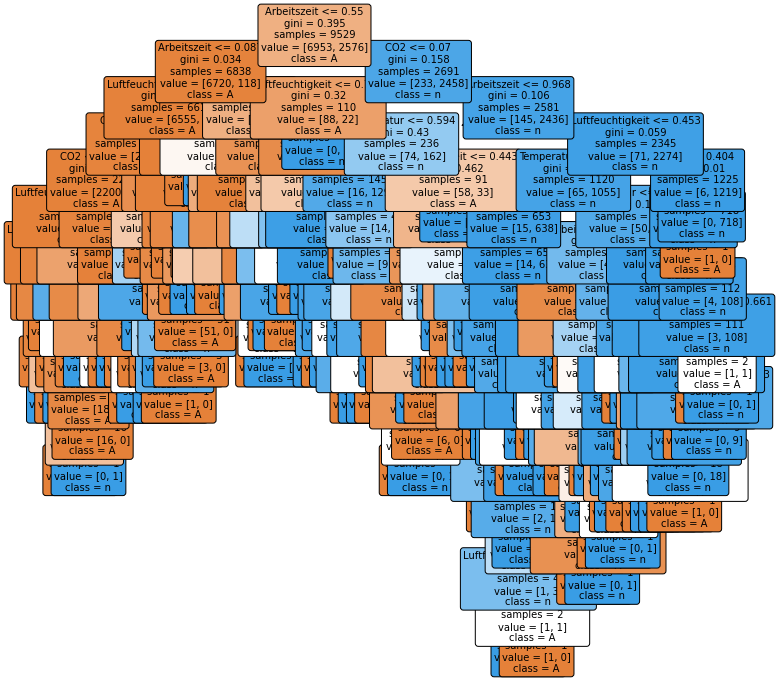

In [212]:
print(pd.DataFrame(columns=df.columns))
X_name = feature_names=list(X.columns)
mDT = DecisionTreeClassifier(**rsDT.best_params_,random_state=42)
mDT.fit(X_train, y_train)

report(mDT)
plt.figure(figsize=(12,12))
plot_tree(mDT, rounded=True, filled=True, class_names=y.reset_index().columns[1], feature_names=X_name, fontsize=10)
plt.show(mDT)
test_viz(mDT)

## SVC

In [215]:
X = df.drop(columns=[label])
y = df[label]
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svc = SVC(random_state=42)
grid = {
"C" : [ 0.1, 1, 10],    
"kernel" : ["poly", "rbf", "sigmoid"], 
"degree" : [1,2,3]
}

rsSV = GridSearchCV(svc, grid, cv = 5)
rsSV.fit(X_train, y_train)
print(rsSV.best_params_)
print(rsSV.score(X_test, y_test))

Index(['Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Arbeitszeit'], dtype='object')
{'C': 10, 'degree': 1, 'kernel': 'rbf'}
0.9726156751652503


In [216]:
mSVC = SVC(**rsSV.best_params_)
mSVC.fit(X_train, y_train)

report(mSVC)
df_test["Anwesenheit"] = mSVC.predict(scaler.transform(df_test))
px.bar(df_test.resample("10min").mean(),y="CO2",color="Anwesenheit").show()
df_test.drop(columns="Anwesenheit",inplace=True)

Trainingsdaten:
               precision    recall  f1-score   support

           0      0.985     0.984     0.985      6953
           1      0.958     0.960     0.959      2576

    accuracy                          0.978      9529
   macro avg      0.971     0.972     0.972      9529
weighted avg      0.978     0.978     0.978      9529

Testdaten:
               precision    recall  f1-score   support

           0      0.987     0.976     0.981      2362
           1      0.932     0.963     0.947       815

    accuracy                          0.973      3177
   macro avg      0.960     0.970     0.964      3177
weighted avg      0.973     0.973     0.973      3177



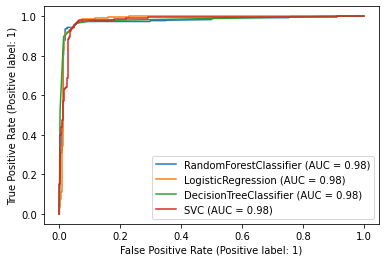

In [186]:
#Plottet die ROC-Kurve
classifiers = [mRF,mLR,mDT,mSVC]
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=plt.gca())

In [187]:
# Gemittelte Vorhersage aller Modelle auf den unbekannten Testdaten
df_temp = pd.DataFrame(df_test.index,index=df_test.index)
df_temp["Anwesenheit"] = (mRF.predict(df_test) + mLR.predict(df_test) + mDT.predict(df_test) + mSVC.predict(df_test))/4
px.bar(df_test.resample("10min").mean(),y="CO2",color=df_temp.resample("10min").mean()["Anwesenheit"])

# Modell welches die geringsten Kosten verursacht

## Kalkulieren der Kosten mit dem Modell

### Ermittlung des anfallenden Kosten in dem Zeitraum mit Wochenende und Stunde

In [250]:
def get_cost(value):
    if value == 0:
        return 0

    else:
        return 1/12

models = {eLR:"logistischer Regression",eSVC:"SVM",eRF:"Random Forest",eDT:"Decision Tree"}
for model, modelName in models.items():
    #Vorbereitung eines Dataframes welcher benutzt wird um die Anzahl an falschen Minuten
    #sowie die Kosten für die Zeit zu ermitteln.
    data = pd.read_csv('train.csv')
    data = data[['Datum','Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Anwesenheit']]
    data['Datum'] = pd.to_datetime(data['Datum'])
    data["Stunde"] = data["Datum"].dt.hour
    data["Wochenende"] = data["Datum"].dt.day_of_week >= 5
    if model in [eLR, eSVC]:
        data = pd.get_dummies(data, columns=['Stunde'])
    data = data.set_index('Datum')
    data.dropna(inplace=True)
    data['Anwesenheit_pred'] = model.predict(MinMaxScaler().fit_transform(data.drop(["Anwesenheit"],axis=1))) 
    # data['Anwesenheit_pred'] = model.predict(data.drop(["Anwesenheit"],axis=1))
    data['Anwesenheit_false'] = (data.Anwesenheit != data.Anwesenheit_pred) & (data.Anwesenheit == 1)
    #Kostenfunktion

    #Resampling auf Stundenebene
    data_h = data[['Anwesenheit_pred']].copy()# .resample('h').max()
    data_h['Kosten'] = data_h['Anwesenheit_pred'].apply(get_cost)
    print(f"Die Kosten betragen bei {modelName}: {data_h['Kosten'].sum().round(2)}€")
    fehler_tag = data[['Anwesenheit_false']].resample('d').sum()
    print(f"Durchschnittliche falsche Minuten pro Tag: {round(fehler_tag[['Anwesenheit_false']].mean()[0])}\n")

Die Kosten betragen bei logistischer Regression: 326.92€
Durchschnittliche falsche Minuten pro Tag: 20

Die Kosten betragen bei SVM: 331.0€
Durchschnittliche falsche Minuten pro Tag: 19

Die Kosten betragen bei Random Forest: 336.0€
Durchschnittliche falsche Minuten pro Tag: 5

Die Kosten betragen bei Decision Tree: 335.42€
Durchschnittliche falsche Minuten pro Tag: 7



### Ermittlung des anfallenden Kosten in dem Zeitraum mit Arbeitszeit als Label

In [231]:
def get_cost(value):
    if value == 0:
        return 0

    else:
        return 1/12

models = {mLR:"logistischer Regression",mSVC:"SVM",mRF:"Random Forest",mDT:"Decision Tree"}
for model, modelName in models.items():
    #Vorbereitung eines Dataframes welcher benutzt wird um die Anzahl an falschen Minuten
    #sowie die Kosten für die Zeit zu ermitteln.
    data = pd.read_csv('train.csv')
    data = data[['Datum','Temperatur', 'Luftfeuchtigkeit', 'CO2', 'Anwesenheit']]
    data['Datum'] = pd.to_datetime(data['Datum'])
    data["Arbeitszeit"] = (data["Datum"].dt.hour.between(8,17))&(data["Datum"].dt.dayofweek < 5)&~((data["Datum"].dt.hour==13)&(data["Datum"].dt.minute.between(0,15)))
    data = data.set_index('Datum')
    data.dropna(inplace=True)
    data['Anwesenheit_pred'] = model.predict(MinMaxScaler().fit_transform(data.drop(["Anwesenheit"],axis=1))) 
    # data['Anwesenheit_pred'] = model.predict(data.drop(["Anwesenheit"],axis=1))
    data['Anwesenheit_false'] = (data.Anwesenheit != data.Anwesenheit_pred) & (data.Anwesenheit == 1)
    #Kostenfunktion

    #Resampling auf Stundenebene
    data_h = data[['Anwesenheit_pred']].copy()# .resample('h').max()
    data_h['Kosten'] = data_h['Anwesenheit_pred'].apply(get_cost)
    print(f"Die Kosten betragen bei {modelName}: {data_h['Kosten'].sum().round(2)}€")
    fehler_tag = data[['Anwesenheit_false']].resample('d').sum()
    print(f"Durchschnittliche falsche Minuten pro Tag: {round(fehler_tag[['Anwesenheit_false']].mean()[0])}\n")


Die Kosten betragen bei logistischer Regression: 347.25€
Durchschnittliche falsche Minuten pro Tag: 13

Die Kosten betragen bei SVM: 336.67€
Durchschnittliche falsche Minuten pro Tag: 15

Die Kosten betragen bei Random Forest: 352.58€
Durchschnittliche falsche Minuten pro Tag: 10

Die Kosten betragen bei Decision Tree: 353.58€
Durchschnittliche falsche Minuten pro Tag: 24

